# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(1883, 132)

# Data EDA and Transformation

In [4]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [5]:
shift=200
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)
print('Skewness of raw loss values: {}'.format(data_train_raw[colRawLabel].skew()))
print('Skewness of log1p loss values: {}'.format(data_train_raw[colLabel].skew()))

Skewness of raw loss values: 3.01855468631
Skewness of log1p loss values: 0.389480535812


In [6]:
# ymean=0
# ystd=1
ymean=data_train_raw[colLabel].min()
ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

In [ ]:
# clean outliers in training data
rescaledMean = data_train_raw[colLabel].mean()
rescaledStd = data_train_raw[colLabel].std()
print('Mean of rescaled log1py: {}'.format(rescaledMean))
print('Std of rescaled log1py: {}'.format(rescaledMean))

lbound = rescaledMean-3*rescaledStd
ubound = rescaledMean+3*rescaledStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw[colLabel]>=lbound) & (data_train_raw[colLabel]<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))
print('Skewness of clipped log1p loss: {}'.format(data_train_raw[colLabel].skew()))

Mean of rescaled log1py: 0.416627782623
Std of rescaled log1py: 0.416627782623
Lower clipping bound: -0.0757800281798
Upper clipping bound: 0.909035593425
Shape of cleaned data: (1879, 133)
Skewness of clipped log1p loss: 0.345052290541


In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [ ]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

In [ ]:
print('Logarithmic transformed, rescaled, clipped loss:')
data_train_raw[colLabel].describe()

# Data preparation - labeling cat features with ordinal information encoded

In [ ]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

In [ ]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

In [ ]:
dataCatAll.head()

In [ ]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
    
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x

dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

In [ ]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

In [ ]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [ ]:
print(x_catAll.shape)
x_catAll

# one-hot-encoding - skipped in order to keep the alphabetical order

In [ ]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# feature engineering with clustering

### testing clustering on training data

In [196]:
d_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
d_train.shape

(1879, 130)

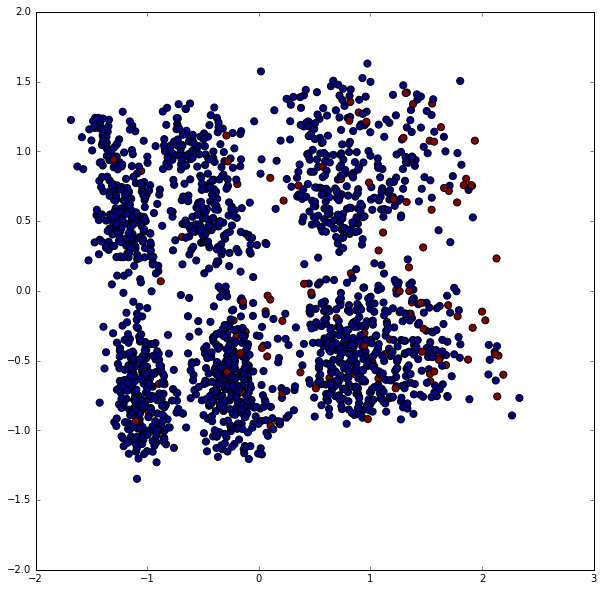

In [197]:
from sklearn.decomposition import PCA
plt.figure(figsize=(10,10))
comp_2 = pca.fit_transform(d_train.todense())
plt.scatter(comp_2[:,0],comp_2[:,1],c=lossRestore(labelSs,ymean,ystd)>8000,s=50)

In [198]:
pca = PCA(random_state=0,n_components = 35)
d_train = pca.fit_transform(d_train.todense())
print(d_train.shape)
print(sum(pca.explained_variance_ratio_))

(1879, 35)
0.851394030573


In [227]:
# from sklearn.metrics import pairwise_distances

# from sklearn.neighbors import DistanceMetric
# def gower_distance(X):
#     """
#     This function expects a pandas dataframe as input
#     The data frame is to contain the features along the columns. Based on these features a
#     distance matrix will be returned which will contain the pairwise gower distance between the rows
#     All variables of object type will be treated as nominal variables and the others will be treated as 
#     numeric variables.
#     Distance metrics used for:
#     Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
#     Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
#     """
#     individual_variable_distances = []

#     for i in range(X.shape[1]):
#         feature = X.iloc[:,[i]]
#         if feature.dtypes[0] == np.object:
#             feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
#         else:
#             feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

#         individual_variable_distances.append(feature_dist)

#     return np.array(individual_variable_distances).mean(0)
# d_train_dist = gower_distance(trainDf)
d_train_dist = pairwise_distances(d_train,metric = 'manhattan')

In [ ]:
# from sklearn.cluster import KMeans
# kms = KMeans(random_state=0,n_jobs=7)
# cluster = kms.fit_predict(d_train)
# cluster

from sklearn.cluster import DBSCAN
# dbs = DBSCAN(n_jobs=7)
dbs = DBSCAN(eps=60,n_jobs=-1,min_samples=10)
# dbs = DBSCAN(eps=1.62,n_jobs=-1,min_samples=5)
cluster = dbs.fit_predict(d_train_dist)
cluster

# from sklearn.cluster import AgglomerativeClustering
# ahc = AgglomerativeClustering(n_clusters=2, compute_full_tree=False, affinity='manhattan',linkage='complete')
# cluster = ahc.fit_predict(d_train)
# cluster

# from kmodes import kmodes
# km = kmodes.KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)
# cluster = km.fit_predict(d_train)
# cluster

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,1,1)
plt.hist(cluster,bins=100);
print(np.unique(cluster))
print(len(np.unique(cluster)))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(comp_2[:,0],comp_2[:,1],c=cluster,s=50)
plt.subplot(1,2,2)
plt.scatter(comp_2[:,0],comp_2[:,1],c=lossRestore(labelSs,ymean,ystd)>8000,s=50)

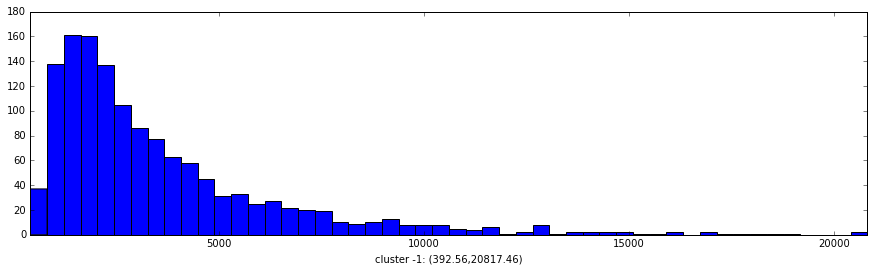

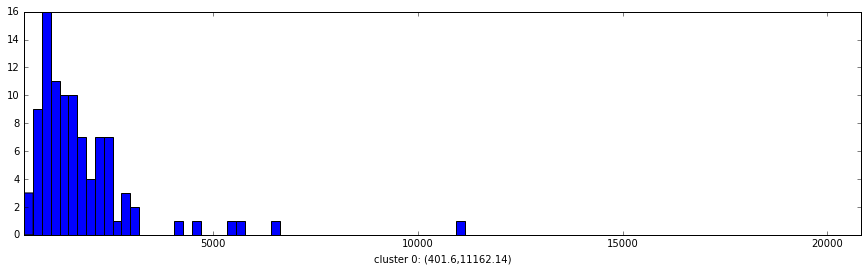

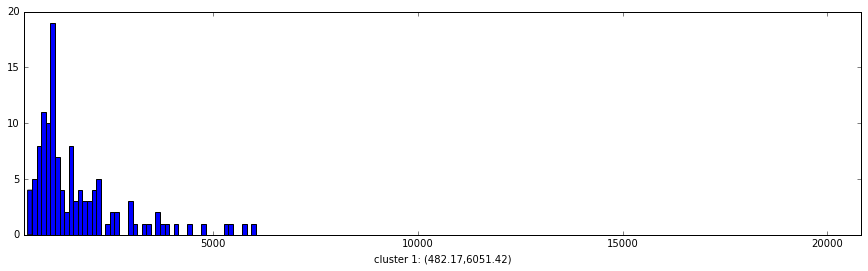

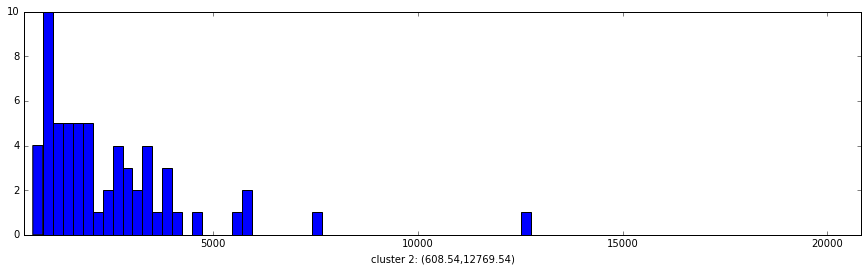

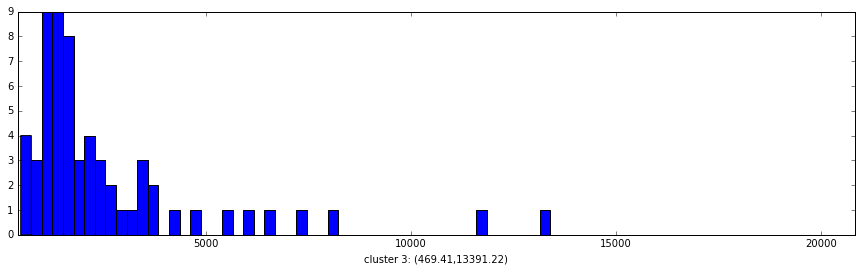

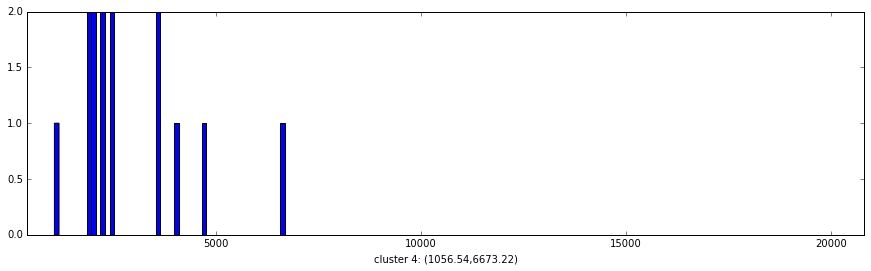

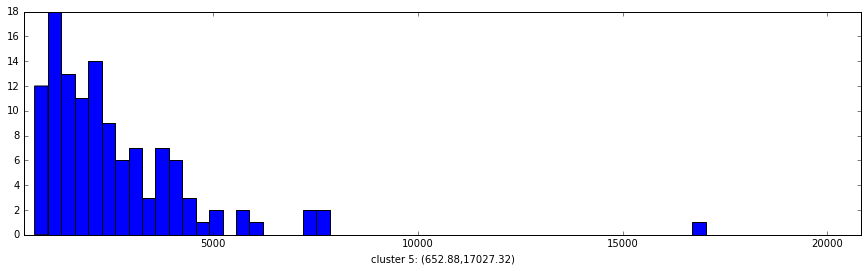

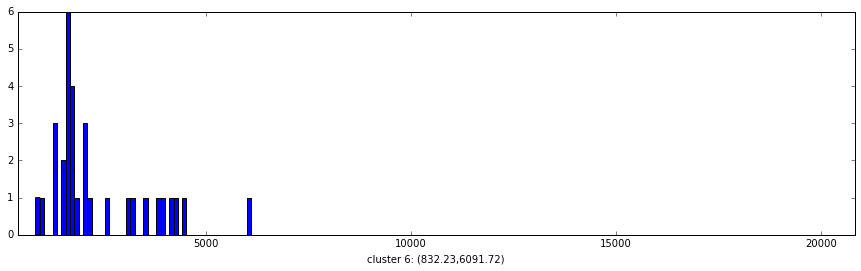

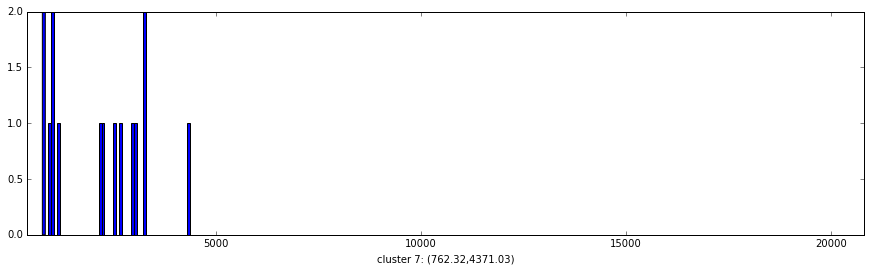

In [226]:
ncluster = len(np.unique(cluster))
listCluster = np.unique(cluster)
for k in listCluster:
    plt.figure(figsize=(15,4))
    plt.subplot(1,1,1)
    plt.hist(lossRestore(labelSs[cluster==k],ymean,ystd),bins=50);
    plt.xlabel('cluster {}: ({},{})'.format(k,np.min(lossRestore(labelSs[cluster==k],ymean,ystd)), np.max(lossRestore(labelSs[cluster==k],ymean,ystd))))
    plt.xlim([lossRestore(labelSs,ymean,ystd).min(), lossRestore(labelSs,ymean,ystd).max()])
#     print('({},{})'.format(np.mean(lossRestore(labelSs[cluster==k],ymean,ystd)),np.std(lossRestore(labelSs[cluster==k],ymean,ystd))))

# split x_train and x_test

In [ ]:
# split x_train and x_test
x_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_test = sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_train = labelSs.values

# check the dimension of prepared data

In [ ]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)

# splite the training data for valication

In [ ]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

In [ ]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
testList = ['XGBoostTrees']

### XGBoost Trees

In [ ]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'mae', mean_absolute_error(preds, labels)

In [ ]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

In [ ]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [ ]:
# params = { 'max_depth': [4, 6, 10], 'min_child_weight':[0,1,2], 'gamma':[0,1,2], \
#            'subsample':[0.5,0.8,1], 'colsample_bytree':[0,1,2], \
#            'eval_metric': 'mae'
#            }
# num_round = 500
# xgbt = GridSearchCV(xgb.XGBRegressor, )

In [ ]:
num_round = 720

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
params = {'eval_metric':'mae','max_depth':12,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist, obj=logregobj, early_stopping_rounds=300)
# gbt = xgb.train(params, d_train_xgb, num_round, watchlist, early_stopping_rounds=300)

In [ ]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

In [ ]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() );

In [ ]:
y_pred_i = gbt.predict(d_test_xgb)
y_pred.append(lossRestore(y_pred_i,ymean,ystd)-shift)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift)
# y_pred_i = gbt.predict(d_test_xgb)
# y_pred.append(y_pred_i)
# y_pred_val.append(gbt.predict(x_val_xgb))

In [ ]:
err_val = lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-lossRestore(y_val,ymean,ystd)
err_val_idx = np.abs(err_val)>10000

plt.figure(figsize=(15,4))
plt.subplot(3,1,1)
plt.hist(err_val,bins=50);
plt.subplot(3,1,2)
plt.hist(lossRestore(y_val,ymean,ystd), bins = 30)
plt.subplot(3,1,3)
plt.hist(lossRestore(y_val[err_val_idx],ymean,ystd), bins = 30)

print(sum(err_val_idx))


In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.subplot(2,1,2)
plt.scatter(lossRestore(y_val[err_val_idx],ymean,ystd),lossRestore(gbt.predict(x_val_xgb)[err_val_idx],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');

# save files for submission

In [ ]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_test, shift]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
